In [ ]:
!nvidia-smi

Mon Mar  4 12:00:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import pandas as pd
import glob

import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join

def load(path, pickle_file, ratio=1):
    dataset = pd.read_pickle(path + pickle_file)
    dataset.info(memory_usage='deep')
    if ratio < 1:
        dataset = get_ratio(dataset, ratio)

    return dataset

def loads(data_sets_dir, ratio=1):
    data_sets_files = sorted([f for f in listdir(data_sets_dir) if isfile(join(data_sets_dir, f))])

    if ratio < 1:
        data_sets_files = get_ratio(data_sets_files, ratio)

    dataset = load(data_sets_dir, data_sets_files[0])
    data_sets_files.remove(data_sets_files[0])

    for ds_file in data_sets_files:
        #dataset = dataset.append(load(data_sets_dir, ds_file))
        # 使用 pd.concat 来连接两个 DataFrame
        dataset = pd.concat([dataset, load(data_sets_dir, ds_file)])


    return dataset

import pandas as pd

def read(path, json_file):
    """
    :param path: str
    :param json_file: str
    :return DataFrame
    """
    return pd.read_json(path + json_file)

def apply_filter(data_frame: pd.DataFrame, filter_func):
    return filter_func(data_frame)

def clean(data_frame: pd.DataFrame):
    return data_frame.drop_duplicates(subset="func", keep=False)

def select(dataset):
    result = dataset.loc[dataset['project'] == "FFmpeg"]
    len_filter = result.func.str.len() < 1200
    result = result.loc[len_filter]
    #print(len(result))
    #result = result.iloc[11001:]
    #print(len(result))
    result = result.head(200)

    return result

def drop(data_frame: pd.DataFrame, keys):
    for key in keys:
        del data_frame[key]

In [ ]:
raw = read("/content/drive/MyDrive/Devign/data/raw/", "dataset.json")

# filtered = apply_filter(raw, select)
filtered = clean(raw)
drop(filtered, ["commit_id", "project"])
filtered = filtered.sample(frac=1, random_state=32)
filtered = filtered.reset_index(drop=True)
filtered

,target,func
0,0,static int serial_parse(const char *devname)\n...
1,0,static void sdl_mouse_mode_change(Notifier *no...
2,1,static int openpic_init(SysBusDevice *dev)\n\n...
3,0,static inline void writer_print_string(WriterC...
4,0,static inline int32_t efsctsi(uint32_t val)\n\...
...,...,...
27193,1,static inline void RENAME(rgb16tobgr24)(const ...
27194,0,static int virtio_ccw_device_init(VirtioCcwDev...
27195,0,"int pit_get_initial_count(PITState *pit, int c..."
27196,0,static int coroutine_fn add_aio_request(BDRVSh...


In [ ]:
import re
import pandas as pd
import csv
from tensorflow.keras import preprocessing
import numpy as np
import json

def load_data_and_write_to_file(train_data_file, test_data_file, test_sample_percentage):

    x_new = []
    y_new = []

    for index, row in filtered.iterrows():
        # 使用index和row访问每一行的数据
        x_new.append(row['func'])
        y_new.append(row['target'])

    # Shuffle data and split data to train and test
    np.random.seed(323)
    np.random.shuffle(x_new)
    np.random.seed(323)
    np.random.shuffle(y_new)
    test_sample_index = -1 * int(test_sample_percentage * len(y_new))
    x_train, x_test = x_new[:test_sample_index], x_new[test_sample_index:]
    y_train, y_test = y_new[:test_sample_index], y_new[test_sample_index:]

    # Write to CSV file
    with open(train_data_file, 'w', newline='', encoding='utf-8-sig') as f:
        print('Write train data to {} ...'.format(train_data_file))
        writer = csv.writer(f)
        writer.writerows(zip(x_train, y_train))
    with open(test_data_file, 'w', newline='', encoding='utf-8-sig') as f:
        print('Write test data to {} ...'.format(test_data_file))
        writer = csv.writer(f)
        writer.writerows(zip(x_test, y_test))

In [ ]:
def preprocess(data_file, vocab_file, padding_size, test=False):
    """
    Text to sequence, compute vocabulary size, padding sequence.
    Return sequence and label.
    """
    print("Loading data from {} ...".format(data_file))
    df = pd.read_csv(data_file, header=None, names=["x_text", "y_label"])
    x_text, y = df["x_text"].tolist(), df["y_label"].tolist()

    if not test:
        # Texts to sequences
        text_preprocesser = preprocessing.text.Tokenizer(oov_token="<UNK>")
        text_preprocesser.fit_on_texts(x_text)
        x = text_preprocesser.texts_to_sequences(x_text)
        word_dict = text_preprocesser.word_index
        json.dump(word_dict, open(vocab_file, 'w'), ensure_ascii=False)
        vocab_size = len(word_dict)
        # max_doc_length = max([len(each_text) for each_text in x])
        x = preprocessing.sequence.pad_sequences(x, maxlen=padding_size,
                                                 padding='post', truncating='post')
        print("Vocabulary size: {:d}".format(vocab_size))
        print("Shape of train data: {}".format(np.shape(x)))
        return x, y, vocab_size
    else:
        word_dict = json.load(open(vocab_file, 'r'))
        vocabulary = word_dict.keys()
        x = [[word_dict[each_word] if each_word in vocabulary else 1 for each_word in each_sentence.split()] for each_sentence in x_text]
        x = preprocessing.sequence.pad_sequences(x, maxlen=padding_size,
                                                 padding='post', truncating='post')
        print("Shape of test data: {}\n".format(np.shape(x)))
        return x, y

In [ ]:
from tensorflow import keras


def TextCNN(vocab_size, feature_size, embed_size, num_classes, num_filters,
            filter_sizes, regularizers_lambda, dropout_rate):
    inputs = keras.Input(shape=(feature_size,), name='input_data')
    embed_initer = keras.initializers.RandomUniform(minval=-1, maxval=1)
    embed = keras.layers.Embedding(vocab_size, embed_size,
                                   embeddings_initializer=embed_initer,
                                   input_length=feature_size,
                                   name='embedding')(inputs)
    # single channel. If using real embedding, you can set one static
    embed = keras.layers.Reshape((feature_size, embed_size, 1), name='add_channel')(embed)

    pool_outputs = []
    print(str(filter_sizes))
    for filter_size in list(map(int, filter_sizes.split(','))):
        filter_size = int(filter_size)
        filter_shape = (filter_size, embed_size)
        conv = keras.layers.Conv2D(num_filters, filter_shape, strides=(1, 1), padding='valid',
                                   data_format='channels_last', activation='relu',
                                   kernel_initializer='glorot_normal',
                                   bias_initializer=keras.initializers.constant(0.1),
                                   name='convolution_{:d}'.format(filter_size))(embed)
        max_pool_shape = (feature_size - filter_size + 1, 1)
        pool = keras.layers.MaxPool2D(pool_size=max_pool_shape,
                                      strides=(1, 1), padding='valid',
                                      data_format='channels_last',
                                      name='max_pooling_{:d}'.format(filter_size))(conv)
        pool_outputs.append(pool)

    pool_outputs = keras.layers.concatenate(pool_outputs, axis=-1, name='concatenate')
    pool_outputs = keras.layers.Flatten(data_format='channels_last', name='flatten')(pool_outputs)
    pool_outputs = keras.layers.Dropout(dropout_rate, name='dropout')(pool_outputs)

    outputs = keras.layers.Dense(num_classes, activation='softmax',
                                 kernel_initializer='glorot_normal',
                                 bias_initializer=keras.initializers.constant(0.1),
                                 kernel_regularizer=keras.regularizers.l2(regularizers_lambda),
                                 bias_regularizer=keras.regularizers.l2(regularizers_lambda),
                                 name='dense')(pool_outputs)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
import argparse
import os
from tensorflow import keras
import tensorflow as tf
from pprint import pprint
import time
from datetime import datetime

def train(x_train, y_train, vocab_size, feature_size, save_path):
    print("\nTrain...")
    model = TextCNN(vocab_size, feature_size, embed_size, num_classes,
                    num_filters, filter_sizes, regularizers_lambda, dropout_rate)
    model.summary()
    #model.compile(tf.optimizers.Adam(), loss='categorical_crossentropy',
    #                       metrics=['accuracy'])

    model.compile(tf.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy(),
                           metrics=[['accuracy'],
                                    keras.metrics.Precision(),
                                    keras.metrics.Recall(),
                                    keras.metrics.F1Score()])

    keras.utils.plot_model(model, show_shapes=True, to_file=os.path.join(results_dir, timestamp, "model.pdf"))
    y_train = tf.one_hot(y_train, num_classes)

    history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs,
                                 validation_split=fraction_validation, shuffle=True)
    print("\nSaving model...")
    keras.models.save_model(model, save_path)
    pprint(history.history)

In [ ]:
fraction_validation

0.05

In [ ]:
import shutil
shutil.rmtree('/content/drive/MyDrive/Devign/textcnn_data', ignore_errors=True)

In [ ]:
import time
test_sample_percentage = 0.1
padding_size = 128
embed_size = 512
filter_sizes = '3,4,5'
num_filters = 128
dropout_rate = 0.5
num_classes = 2
regularizers_lambda = 0.01
batch_size = 64
epochs = 10
fraction_validation = 0.05
results_dir = "/content/drive/MyDrive/Devign/textcnn_data/results/"


if not os.path.exists(results_dir):
    os.mkdir(results_dir)
timestamp = time.strftime("%Y-%m-%d-%H-%M", time.localtime(time.time()))
os.mkdir(os.path.join(results_dir, timestamp))
os.mkdir(os.path.join(results_dir, timestamp, 'log/'))

if not os.path.exists("/content/drive/MyDrive/Devign/textcnn_data/train_data.csv") or not os.path.exists("/content/drive/MyDrive/Devign/textcnn_data/test_data.csv"):
    load_data_and_write_to_file("/content/drive/MyDrive/Devign/textcnn_data/train_data.csv",
                                            "/content/drive/MyDrive/Devign/textcnn_data/test_data.csv", test_sample_percentage)

x_train, y_train, vocab_size = preprocess("/content/drive/MyDrive/Devign/textcnn_data/train_data.csv",
                                                      os.path.join(results_dir, timestamp, "vocab.json"),
                                                      padding_size)

Loading data from /content/drive/MyDrive/Devign/textcnn_data/train_data.csv ...
Vocabulary size: 50136
Shape of train data: (24479, 128)


In [ ]:
type(y_train)

list

In [ ]:
len(y_train)

24479

In [ ]:
count_0 = y_train.count(0)
count_1 = y_train.count(1)

print(f"Count of 0: {count_0}")
print(f"Count of 1: {count_1}")

Count of 0: 13361
Count of 1: 11118


In [ ]:
train(x_train, y_train, vocab_size, padding_size, os.path.join(results_dir, timestamp, 'TextCNN.h5'))


Train...
3,4,5
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_data (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 128, 512)             2566963   ['input_data[0][0]']          
                                                          2                                       
                                                                                                  
 add_channel (Reshape)       (None, 128, 512, 1)          0         ['embedding[0][0]']           
                                                                                                  
 convolution_3 (Conv2D)      (None, 126, 1, 128)          196736    ['add_c

<ipython-input-65-396184d92789>:29: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, save_path)


{'accuracy': [0.5616856813430786,
              0.6442915797233582,
              0.6931412816047668,
              0.7406579256057739,
              0.7794452905654907,
              0.8119974136352539,
              0.8319501280784607,
              0.8540098667144775,
              0.8669533729553223,
              0.8777897357940674],
 'f1_score': [array([0.6150535, 0.4911387], dtype=float32),
              array([0.6868327 , 0.58837575], dtype=float32),
              array([0.7250096, 0.6529182], dtype=float32),
              array([0.7658864, 0.7093354], dtype=float32),
              array([0.79993755, 0.7542758 ], dtype=float32),
              array([0.82891136, 0.79137236], dtype=float32),
              array([0.8467932, 0.8139225], dtype=float32),
              array([0.866753 , 0.8385716], dtype=float32),
              array([0.8783805 , 0.85315615], dtype=float32),
              array([0.8881719 , 0.86528254], dtype=float32)],
 'loss': [0.7829039692878723,
          0.638246

In [ ]:
import argparse
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import os


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def test(model, x_test, y_test):
    print("Test...")
    y_pred_one_hot = model.predict(x=x_test, batch_size=1, verbose=1)
    y_pred = tf.math.argmax(y_pred_one_hot, axis=1)

    plot_confusion_matrix(y_test, y_pred, np.arange(num_classes))
    plt.savefig(os.path.join(results_dir, "confusion_matrix.pdf"))

    print('\nTest accuracy: {}\n'.format(accuracy_score(y_test, y_pred)))
    print('Classification report:')
    target_names = ['class {:d}'.format(i) for i in np.arange(num_classes)]
    print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

Loading data from /content/drive/MyDrive/Devign/textcnn_data/test_data.csv ...
Shape of test data: (2719, 128)

Loading model...
Test...
2719/2719 [==============================] - 6s 2ms/step
Confusion matrix, without normalization
[[1425   12]
 [1281    1]]

Test accuracy: 0.5244575211474807

Classification report:
              precision    recall  f1-score   support

     class 0     0.5266    0.9916    0.6879      1437
     class 1     0.0769    0.0008    0.0015      1282

    accuracy                         0.5245      2719
   macro avg     0.3018    0.4962    0.3447      2719
weighted avg     0.3146    0.5245    0.3643      2719



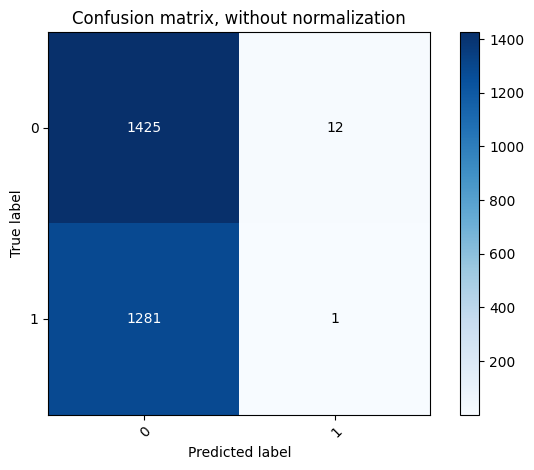

In [ ]:
results_dir = "/content/drive/MyDrive/Devign/textcnn_data/results/"
padding_size = 128
num_classes = 2


x_test, y_test = preprocess("/content/drive/MyDrive/Devign/textcnn_data/test_data.csv", "/content/drive/MyDrive/Devign/textcnn_data/results/2024-03-04-12-27/vocab.json",
                            padding_size, test=True)
print("Loading model...")
model = load_model("/content/drive/MyDrive/Devign/textcnn_data/results/2024-03-04-12-27/TextCNN.h5")
test(model, x_test, y_test)

In [1]:
def calculate_f1(precision, recall):
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

# 例子：
precision = 0.5903
recall = 0.5772

f1_score = calculate_f1(precision, recall)
print("F1 score:", f1_score)

F1 score: 0.5836765053533192
